# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [25]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2


# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# models
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
# xgboost
#from xgboost import XGBClassifier

# processing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection

# feature selection
from sklearn.feature_selection import SelectFdr, f_classif, SelectKBest, SelectFromModel, VarianceThreshold, chi2

# benchmark
import random
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle
import shap
import eli5
from eli5.sklearn import PermutationImportance

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = 1.2)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [2]:
model_file = "../../../dataset/5_McNemar_PDX_30x/OmicsBinary_StackingCVClassifier_mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster0.pkl"
classifier = pickle.load(open(model_file, 'rb'))
X_file = "../../../dataset/5_McNemar_PDX_30x/mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster0_Xtest.tsv"
X_test = pd.read_csv(X_file, sep='\t', header=0, index_col=0)
target_col = "Cetuximab_Standard_3wks_cat"
Y_file =  "../../../dataset/5_McNemar_PDX_30x/OmicsBinary0_Ytest.tsv"
Y_test = pd.read_csv(Y_file, sep='\t', header=0, index_col=0)
response_file = "../../../dataset/5_McNemar_PDX_30x/DrugResponse_LMXfirslevel_trainTest0.tsv" 
response = pd.read_csv(response_file, sep='\t', header=0, index_col=1)

# Results
Show graphs and stats here

### Assess model performance on test set

In [3]:
# assess classifier performance on test set
grid_test_score = classifier.score(X_test, Y_test)
y_pred = classifier.predict(X_test)
print(f'Accuracy on test set: {grid_test_score:.3f}')
print(classification_report(Y_test, y_pred, target_names=['PD', 'SD+OR']))

Accuracy on test set: 0.829
              precision    recall  f1-score   support

          PD       0.82      0.82      0.82        33
       SD+OR       0.84      0.84      0.84        37

    accuracy                           0.83        70
   macro avg       0.83      0.83      0.83        70
weighted avg       0.83      0.83      0.83        70



(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

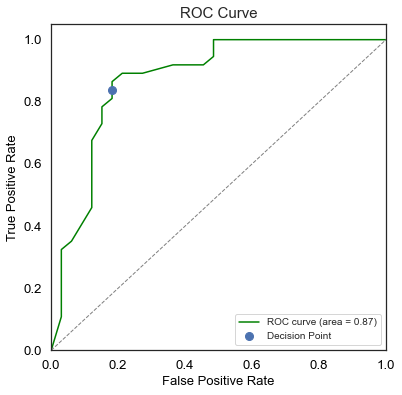

In [4]:
# returns the marginal probability that the given sample has the label in question
y_test_predict_proba = classifier.predict_proba(X_test)
# plot ROC
fp_rates, tp_rates, _ = roc_curve(Y_test,y_test_predict_proba[:,1])
roc_auc = auc(fp_rates, tp_rates)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fp_rates, tp_rates, color='green',
            lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')

#plot decision point:
cm = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = [i for i in cm.ravel()]
plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title('ROC Curve', size=15)
plt.legend(loc="lower right", prop={'size': 10})
plt.subplots_adjust(wspace=.3)
plt.savefig("bestStackedCVClassifier_AUC.pdf", 
                format='pdf', dpi=720, bbox_inches='tight')

In [31]:
# load triple negative feature
f = '../../../dataset/5_McNemar_PDX_30x/preproc_mut0.tsv'
tripleNeg_df = pd.read_csv(f, sep='\t', header=0, 
			index_col=0)['KRAS_BRAF_NRAS_triple_neg']
# merge KRAS-NRAS-BRAF predictions, stacked prediction, truth
stacked_y_pred = pd.Series(classifier.predict(X_test), index=X_test.index)
tripleNeg_y_pred = tripleNeg_df.loc[X_test.index]
pred_df = pd.DataFrame.from_dict({'Y' : Y_test.values[:,0],
				'rand_cont' : [random.uniform(0, 1) for i in range(len(Y_test))],
				'stackedCVClassifier' : stacked_y_pred.values,
				'stackedCVClassifier_prob' : y_test_predict_proba[:,1],
				'tripleNeg' : tripleNeg_y_pred.values})
pred_df

,Y,rand_cont,stackedCVClassifier,stackedCVClassifier_prob,tripleNeg
0,1,0.615780,1,0.768104,1.0
1,0,0.403155,0,0.246648,0.0
2,1,0.254367,1,0.658445,1.0
3,0,0.456337,1,0.659435,1.0
4,0,0.541173,0,0.338264,0.0
...,...,...,...,...,...
65,1,0.025544,1,0.613985,1.0
66,0,0.757720,0,0.457973,1.0
67,1,0.194662,1,0.615029,1.0
68,0,0.380512,0,0.284084,1.0


In [59]:
# how many additional (compared to the KRAS-BRAF-NRAS signature) tripleNeg==1 models do we correctly categorise as non-responders (aka PD)?
tripleNegResistAll_count = pred_df[(pred_df.Y==0) & (pred_df.tripleNeg ==1)].index.nunique()
tripleNegResistPredicted_count = pred_df[(pred_df.Y==0) & (pred_df.tripleNeg ==1) & (pred_df.stackedCVClassifier == 0)].index.nunique() 
ResistPredicted_count = pred_df[(pred_df.Y==0) & (pred_df.tripleNeg ==0)].index.nunique() 
tripleNegResistPredicted_count / ResistPredicted_count  # new predicted / previously predicted

0.16

In [60]:
# how many additional (compared to the KRAS-BRAF-NRAS signature) tripleNeg==0 models do we correctly categorise as responders (aka SD-OR)?
tripleNegRespondAll_count = pred_df[(pred_df.Y==1) & (pred_df.tripleNeg ==0)].index.nunique()
tripleNegRespondPredicted_count = pred_df[(pred_df.Y==1) & (pred_df.tripleNeg ==0) & (pred_df.stackedCVClassifier == 1)].index.nunique() 
RespondPredicted_count = pred_df[(pred_df.Y==1) & (pred_df.tripleNeg == 1)].index.nunique() 
tripleNegRespondPredicted_count / RespondPredicted_count # new predicted / previously predicted 

0.0

In [40]:
f = '../../../dataset/5_McNemar_PDX_30x/DrugResponse_LMXfirslevel_trainTest0.tsv'
response_df = pd.read_csv(f, sep='\t', header=0, 
			index_col=1)
response_df.Cetuximab_Standard_3wks_cat.value_counts()			

OR+SD    122
PD       109
Name: Cetuximab_Standard_3wks_cat, dtype: int64

In [50]:
df1 = pd.concat([response_df.Cetuximab_Standard_3wks_cat, tripleNeg_df], axis=1)
df1.groupby('Cetuximab_Standard_3wks_cat').KRAS_BRAF_NRAS_triple_neg.value_counts(normalize=True)
df1.value_counts()


Cetuximab_Standard_3wks_cat  KRAS_BRAF_NRAS_triple_neg
OR+SD                        1.0                          0.893443
                             0.0                          0.106557
PD                           0.0                          0.651376
                             1.0                          0.348624
Name: KRAS_BRAF_NRAS_triple_neg, dtype: float64

Cetuximab_Standard_3wks_cat  KRAS_BRAF_NRAS_triple_neg
OR+SD                        1.0                          109
PD                           0.0                           71
                             1.0                           38
OR+SD                        0.0                           13
dtype: int64

### Investigate wrong predictions

In [5]:
# aggregate true labels, predictions, prediction prob
pred_df = pd.concat([pd.Series(arr) for arr in [Y_test[target_col].values,
                                                 y_pred, 
                                                 y_test_predict_proba[:, 1]]], axis=1, ignore_index=True)
pred_df.index = Y_test.index
pred_df.columns = ["y", "pred", "prob_SD-OR"]
pred_df["ircc_id"] =Y_test.index

pred_df["correct"] = pred_df.y == pred_df.pred
pred_df["pseudo_residual"] = np.abs(pred_df.y - pred_df["prob_SD-OR"])
# wrong predictions on test
# sorted by model confidence in the wrong pred
wrong_df = pred_df[pred_df.correct == False].sort_values('pseudo_residual', ascending=False)
# right predictions on test sorted by confidence
right_df = pred_df[pred_df.correct == True].sort_values('pseudo_residual')
# add prediction labels
Y_val_dict = Y_class_dict={0:'PD', 1:'SD-OR'}
pred_df["y_label"] = pred_df.y.replace(Y_val_dict)
pred_df["pred_label"] = pred_df.pred.replace(Y_val_dict)
# add disaggregated labels, continous target variableSpred_df
pred_df = pd.merge(pred_df,
                   response,
                   left_index=True, right_index=True)
# separate wrong predictions according to error type
wrong_PD_preds = pred_df[(pred_df.y_label == 'SD-OR') & (pred_df.pred_label == 'PD')]
wrong_SDOR_preds = pred_df[(pred_df.y_label == 'PD') & (pred_df.pred_label == 'SD-OR')]

<AxesSubplot:xlabel='Cetuximab_Standard_3wks', ylabel='Density'>

<AxesSubplot:xlabel='Cetuximab_Standard_3wks', ylabel='Density'>

<AxesSubplot:xlabel='Cetuximab_Standard_3wks', ylabel='Density'>

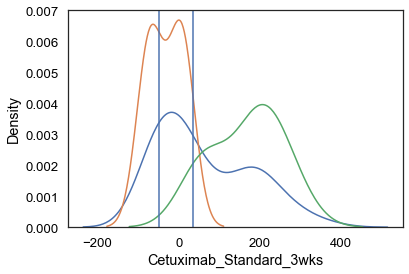

In [6]:
sb.kdeplot(data=pred_df['Cetuximab_Standard_3wks'], label="all")
sb.kdeplot(data=wrong_PD_preds['Cetuximab_Standard_3wks'], label="Y:SD-OR;P:PD")
sb.kdeplot(data=wrong_SDOR_preds['Cetuximab_Standard_3wks'], label="Y:PD;P:SD-OR")
ax = plt.gca()
plt.axvline(x=35)
plt.axvline(x=-50)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


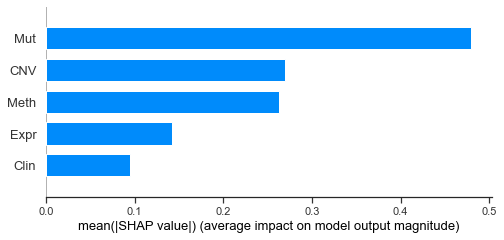

In [7]:
# build a linear shap explainer (not Explainer Tree) for meta classifier on test set
meta_features_train = classifier.predict_meta_features(X_test)
meta_feature_names = ['Meth', 'Expr', 'Mut', 'CNV', 'Clin']
explainer =  shap.explainers.Linear(classifier.meta_clf_,
                                    masker=meta_features_train,
                                    data=meta_features_train,
                                    model_output='raw',
                                    feature_perturbation='interventional',
                                    class_names=["PD", "OR-SD"],
                                    feature_names=meta_feature_names)
meta_shap_values = explainer.shap_values(meta_features_train)

g = shap.summary_plot(meta_shap_values, 
                meta_features_train, 
                feature_names=meta_feature_names,
                show=True, # to save plot to file 
                plot_type="bar",
                max_display=20)

In [8]:
#Importing the module
from eli5 import show_weights, explain_weights_df,format_as_image 
from eli5.sklearn import PermutationImportance#Permutation Importance
perm = PermutationImportance(classifier, scoring = 'accuracy',random_state=101).fit(X_test, Y_test)
explain_weights_df = explain_weights_df(perm, feature_names = list(X_test.columns))

In [10]:
explain_weights_df.sort_values('weight', ascending=False).head(20) 

,feature,weight,std
0,KRAS_BRAF_NRAS_triple_neg_mut,0.148571,0.019378
1,KRAS_mut,0.065714,0.029416
2,3,0.040000,0.005714
3,NRAS_mut,0.028571,0.020203
4,4,0.025714,0.026186
5,TP53_mut,0.020000,0.014569
6,PCBP1_mut,0.020000,0.006999
7,FOXA2_highGain_cnv,0.017143,0.010690
8,CRNKL1_highGain_cnv,0.017143,0.016660
9,5,0.014286,0.000000


Text(0, 0.5, '')

Text(0.5, 0, 'ELI5 Permutation Importance')

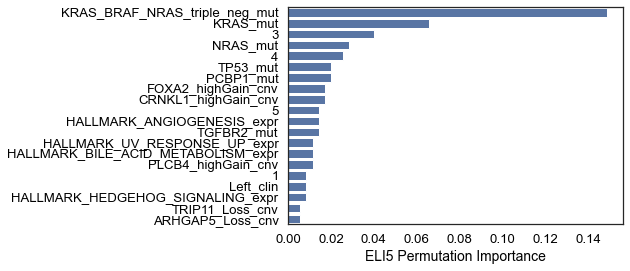

In [22]:
plot_df = explain_weights_df.sort_values('weight', ascending=False).head(20) 
ax = sb.barplot(x="weight",
                    y="feature",
                    color='b', 
                    data=plot_df)
ax.set_ylabel("")
ax.set_xlabel("ELI5 Permutation Importance", fontsize=14)
#plt.yticks(rotation=30)
plt.savefig("ELI5_PermImportance_barplot.pdf", 
                format='pdf', dpi=720, bbox_inches='tight')

# Conclusions and Next Steps
Summarize findings here